## 1. Prepare Features & Target

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

credit_df = pd.read_csv("../data/raw/creditcard.csv")

In [5]:
X = credit_df.drop(['Class'], axis=1)
y = credit_df['Class']


## 2. Train-Test Split

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## 3. Handle Class Imbalance

In [13]:
# Undersample majority
fraud_minority = fraud_df[fraud_df['class']==1]
fraud_majority = fraud_df[fraud_df['class']==0].sample(len(fraud_minority), random_state=42)
balanced_df = pd.concat([fraud_minority, fraud_majority])


class
1    14151
0    14151
Name: count, dtype: int64


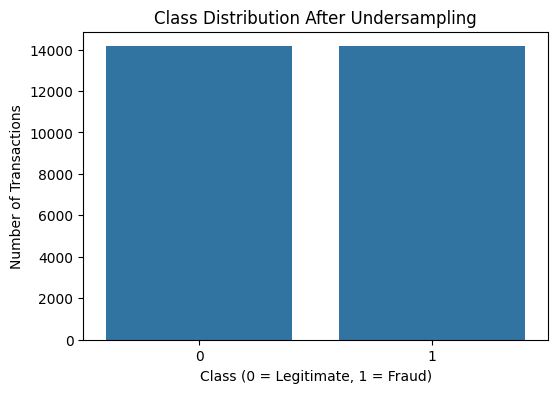

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: manual undersampling
fraud_minority = fraud_df[fraud_df['class'] == 1]
fraud_majority = fraud_df[fraud_df['class'] == 0].sample(len(fraud_minority), random_state=42)

balanced_df = pd.concat([fraud_minority, fraud_majority])

# Check the new class distribution
print(balanced_df['class'].value_counts())

# Plot
plt.figure(figsize=(6,4))
sns.countplot(x='class', data=balanced_df)
plt.title('Class Distribution After Undersampling')
plt.xlabel('Class (0 = Legitimate, 1 = Fraud)')
plt.ylabel('Number of Transactions')
plt.show()


# Importing Libraries

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [24]:
# Load data
df = pd.read_csv(r"C:\Users\Dell\Pictures\fraud-detection\data\processed\fraud_data_processed.csv")  

# Define target
TARGET = "class"  # or "class"

X = df.drop(columns=[])
y = df[TARGET]

# Train-test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)


In [26]:
X_train.dtypes


user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object

## Clean + Feature Engineering

### Step 1: Drop useless identifier columns

In [27]:
df = df.drop(columns=["user_id", "device_id", "ip_address"])

### Step 2: Convert timestamps to useful features

In [ ]:
df["signup_time"] = pd.to_datetime(df["signup_time"])
df["purchase_time"] = pd.to_datetime(df["purchase_time"])

df["signup_hour"] = df["signup_time"].dt.hour
df["signup_dayofweek"] = df["signup_time"].dt.dayofweek

df["purchase_hour"] = df["purchase_time"].dt.hour
df["purchase_dayofweek"] = df["purchase_time"].dt.dayofweek

# Optional but powerful feature
df["time_to_purchase"] = (
    df["purchase_time"] - df["signup_time"]
).dt.total_seconds()

df = df.drop(columns=["signup_time", "purchase_time"])

### 3. Encode categorical features

In [30]:
df = pd.get_dummies(
    df,
    columns=["source", "browser", "sex"],
    drop_first=True
)

### 4. Split features and target

In [ ]:
X = df.drop(columns=["class"])
y = df["class"]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

### 5. Scale the numeric features

In [32]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [33]:
print(X_train.shape)
print(X_test.shape)

(22641, 14)
(5661, 14)


## Baseline Model – Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, average_precision_score

lr = LogisticRegression(
    class_weight="balanced",
    max_iter=1000,
    n_jobs=-1
)

lr.fit(X_train, y_train)

y_pred = lr.predict(X_test)
y_proba = lr.predict_proba(X_test)[:, 1]


c:\Users\Dell\Pictures\fraud-detection\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  


## Evaluation

AUC-PR: 0.8150336189975949
              precision    recall  f1-score   support

           0       0.69      0.63      0.66      2831
           1       0.66      0.71      0.69      2830

    accuracy                           0.67      5661
   macro avg       0.67      0.67      0.67      5661
weighted avg       0.67      0.67      0.67      5661



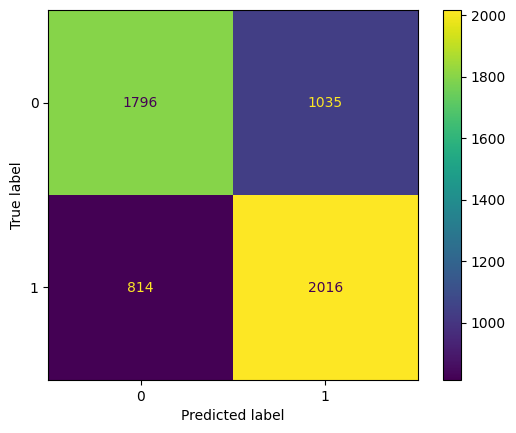

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

print("AUC-PR:", average_precision_score(y_test, y_proba))
print(classification_report(y_test, y_pred))

ConfusionMatrixDisplay.from_predictions(y_test, y_pred)

## Ensemble Model (Random Forest Example)

In [36]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    class_weight="balanced",
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]


## Evaluation:

AUC-PR: 0.8459334250218031
              precision    recall  f1-score   support

           0       0.69      1.00      0.82      2831
           1       1.00      0.55      0.71      2830

    accuracy                           0.78      5661
   macro avg       0.84      0.78      0.76      5661
weighted avg       0.84      0.78      0.76      5661



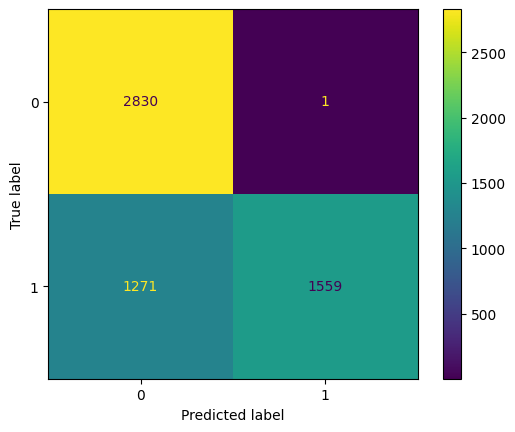

In [39]:
print("AUC-PR:", average_precision_score(y_test, y_proba_rf))
print(classification_report(y_test, y_pred_rf))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred_rf)

## Cross-Validation 

### Use Stratified K-Fold to get stable estimates.

In [42]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_scores = cross_val_score(
    rf,
    X,
    y,
    cv=skf,
    scoring="average_precision",
    n_jobs=1   # ← IMPORTANT FIX
)

print(f"Mean AUC-PR: {cv_scores.mean():.4f}")
print(f"Std AUC-PR:  {cv_scores.std():.4f}")

Mean AUC-PR: 0.8398
Std AUC-PR:  0.0041


## Compute ROC–AUC for each model

### Step 1: Get predicted probabilities

In [43]:
from sklearn.metrics import roc_auc_score

# Logistic Regression
y_proba_lr = lr.predict_proba(X_test)[:, 1]
auc_lr = roc_auc_score(y_test, y_proba_lr)

# Random Forest
y_proba_rf = rf.predict_proba(X_test)[:, 1]
auc_rf = roc_auc_score(y_test, y_proba_rf)

print(f"Logistic Regression ROC-AUC: {auc_lr:.4f}")
print(f"Random Forest ROC-AUC:      {auc_rf:.4f}")


Logistic Regression ROC-AUC: 0.7640
Random Forest ROC-AUC:      0.7811


### 3. Plot ROC curves (visual comparison)

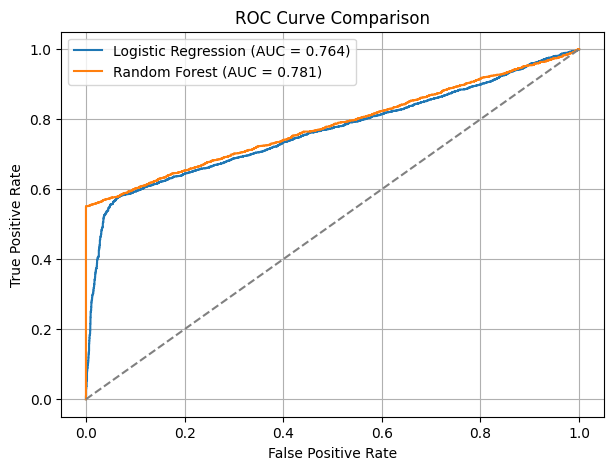

In [44]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)

plt.figure(figsize=(7, 5))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {auc_lr:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.3f})")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.grid(True)
plt.show()


### 4. Cross-validated ROC-AUC

In [45]:
from sklearn.model_selection import StratifiedKFold, cross_val_score

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

cv_auc_lr = cross_val_score(
    lr, X, y, cv=skf, scoring="roc_auc", n_jobs=1
)

cv_auc_rf = cross_val_score(
    rf, X, y, cv=skf, scoring="roc_auc", n_jobs=1
)

print(f"Logistic Regression CV AUC: {cv_auc_lr.mean():.4f} ± {cv_auc_lr.std():.4f}")
print(f"Random Forest CV AUC:      {cv_auc_rf.mean():.4f} ± {cv_auc_rf.std():.4f}")


c:\Users\Dell\Pictures\fraud-detection\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  
c:\Users\Dell\Pictures\fraud-detection\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  
c:\Users\Dell\Pictures\fraud-detection\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  
c:\Users\Dell\Pictures\fraud-detection\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1184: FutureWarning: 'n_jobs' has no effect since 1.8 and will be removed in 1.10. You provided 'n_jobs=-1', please leave it unspecified.
  
c:\Users\Dell\Pictures\fraud-detection\.venv\Lib

Logistic Regression CV AUC: 0.7464 ± 0.0035
Random Forest CV AUC:      0.7745 ± 0.0065


## Task 3 — Model Explainability (SHAP)

### 1. Feature Importance (Baseline – Model-Based)